In [76]:
from libraries import *
from dataclasses import dataclass
from funtions import get_portfolio_value
from backtest import  Position

data = pd.read_csv('Binance_BTCUSDT_1h.csv', skiprows=1).dropna()
data['Date'] = pd.to_datetime(data['Date'], format='mixed')
data.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1758582000000,2025-09-22 23:00:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.31095,1.524494e+07,34083
1,1758578400000,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.60715,3.264691e+07,42836
2,1758574800000,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.31156,3.307493e+07,42931
3,1758571200000,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.84005,6.707508e+07,93553
4,1758567600000,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.37365,1.467768e+08,126232


In [77]:
pd.DataFrame(data.isnull().sum()).T

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,0,0,0,0,0,0,0,0,0,0


In [78]:
def backtest(data, capital, trial) -> float:
    data = data.copy()
    initial_capital = float(capital)

    # Indicadores e Hyperparametros
    # -- RSI -- Es el momentum de sobrecompra y sobreventa
    # -- Momentum -- Mide la velocidad del cambio del precio
    # -- Volatilidad -- Mide la variación del precio en el tiempo

    rsi_window = trial.suggest_int('rsi_window', 46, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 45, 55)
    rsi_upper = trial.suggest_int('rsi_upper', 55, 70)

    momentum_window = trial.suggest_int('momentum_window', 5, 50)
    momentum_threshold = trial.suggest_float('momentum_threshold', 0, 10)

    volatility_window = trial.suggest_int('volatility_window', 5, 30)
    volatility_threshold = trial.suggest_float('volatility_threshold', 4, 7)

    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    # --- Indicadores ---
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=rsi_window).rsi()
    data['Momentum'] = ta.momentum.ROCIndicator(data['Close'], window=momentum_window).roc()
    data['Volatility'] = ta.volatility.BollingerBands(data['Close'], window=volatility_window).bollinger_wband()

    # --- Señales ---
    data['buy_signal'] = ((data['RSI'] < rsi_lower) &
                         (data['Momentum'] > momentum_threshold) &
                         (data['Volatility'] < volatility_threshold))

    data['sell_signal'] = ((data['RSI'] > rsi_upper) &
                          (data['Momentum'] < -momentum_threshold) &
                          (data['Volatility'] > volatility_threshold))

    # --- Backtest ---
    cash = float(capital)  
    active_long_positions: List[Position] = []
    active_short_positions: List[Position] = []

    COM: float = 0.125 / 100  

    max_positions_per_side = 1

    portfolio_values = [initial_capital]

    # Loop de barras
    for i, row in data.iterrows():
        price = row.Close

        # -- LONG--
        for pos in active_long_positions.copy():
            if price >= pos.tp or price <= pos.sl:
                # cerramos: vendemos al precio actual descontando comisión
                sell_proceeds = price * pos.n_shares * (1 - COM)
                cash += sell_proceeds
                active_long_positions.remove(pos)

        # -- SHORT--
        for pos in active_short_positions.copy():
            if price <= pos.tp or price >= pos.sl:
                # cerramos el short: recompramos al precio actual (buy to cover) + comisión
                buy_cost = price * pos.n_shares * (1 + COM)
                cash -= buy_cost
                active_short_positions.remove(pos)

        # --- Entradas ---
        # Long 
        if getattr(row, "buy_signal", False):
            if len(active_long_positions) < max_positions_per_side:
                cost = price * n_shares * (1 + COM)  # costo de entrada (compra)
                if cash >= cost:
                    cash -= cost
                    pos = Position(
                        ticker='BTCUSDT', n_shares=n_shares, price=price,
                        sl=price * (1 - stop_loss), tp=price * (1 + take_profit),
                        time=getattr(row, "Datetime", None),
                        side="long"
                    )
                    active_long_positions.append(pos)

        # Short 
        if getattr(row, "sell_signal", False):
            if len(active_short_positions) < max_positions_per_side:
                entry_cash = price * n_shares * (1 - COM)
                cash += entry_cash
                pos = Position(
                    ticker='BTCUSDT', n_shares=n_shares, price=price,
                    sl=price * (1 + stop_loss), tp=price * (1 - take_profit),
                    time=getattr(row, "Datetime", None),
                    side="short"
                )
                active_short_positions.append(pos)

        # --- Valor del portafolio ---
        unrealized_long = sum((price - p.price) * p.n_shares for p in active_long_positions)
        unrealized_short = sum((p.price - price) * p.n_shares for p in active_short_positions)
        total_value = cash + unrealized_long + unrealized_short
        portfolio_values.append(total_value)

    # Al final del backtest: cerrar todas las posiciones abiertas al último precio 
    final_price = data.iloc[-1].Close
    for pos in active_long_positions:
        cash += final_price * pos.n_shares * (1 - COM)
    for pos in active_short_positions:
        cash -= final_price * pos.n_shares * (1 + COM)

    final_portfolio_value = cash  

    retorno_relativo = float(final_portfolio_value / initial_capital - 1)
    return retorno_relativo


In [79]:
capital = 1_000_000
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, capital, trial), n_trials=50, n_jobs=-1)


[I 2025-09-30 19:55:09,827] A new study created in memory with name: no-name-75365857-1a02-4a3e-9320-29a12a63c107
[I 2025-09-30 19:55:36,303] Trial 0 finished with value: -0.7706515729624898 and parameters: {'rsi_window': 50, 'rsi_lower': 52, 'rsi_upper': 58, 'momentum_window': 8, 'momentum_threshold': 0.797462200290262, 'volatility_window': 29, 'volatility_threshold': 6.715624776466587, 'stop_loss': 0.10600526548890328, 'take_profit': 0.12707290014089684, 'n_shares': 73}. Best is trial 0 with value: -0.7706515729624898.
[I 2025-09-30 19:55:43,085] Trial 1 finished with value: 0.0 and parameters: {'rsi_window': 47, 'rsi_lower': 46, 'rsi_upper': 70, 'momentum_window': 50, 'momentum_threshold': 4.709985667131855, 'volatility_window': 10, 'volatility_threshold': 4.938288257365662, 'stop_loss': 0.05399066199255674, 'take_profit': 0.12313702827662704, 'n_shares': 497}. Best is trial 1 with value: 0.0.
[I 2025-09-30 19:55:46,118] Trial 2 finished with value: -0.016870080749998184 and paramet

In [80]:
study.best_params

{'rsi_window': 46,
 'rsi_lower': 55,
 'rsi_upper': 61,
 'momentum_window': 39,
 'momentum_threshold': 9.832672181473127,
 'volatility_window': 5,
 'volatility_threshold': 4.071680648899033,
 'stop_loss': 0.013343483715254775,
 'take_profit': 0.010338586020742195,
 'n_shares': 255}

In [81]:
study.best_value

0.04843112043750031

----


# Con parametros optimización


In [82]:
params = {
    'rsi_window': study.best_params['rsi_window'],
    'rsi_lower': study.best_params['rsi_lower'],
    'rsi_upper': study.best_params['rsi_upper'],
    'momentum_window': study.best_params['momentum_window'],
    'momentum_threshold': study.best_params['momentum_threshold'],
    'volatility_window': study.best_params['volatility_window'],
    'volatility_threshold': study.best_params['volatility_threshold'],
    'stop_loss': study.best_params['stop_loss'],
    'take_profit': study.best_params['take_profit'],
    'n_shares': study.best_params['n_shares']
}




def backtest(data, capital, params) -> float:
    # en vez de usar trial.suggest, tomamos params directo
    rsi_window = params['rsi_window']
    rsi_lower = params['rsi_lower']
    rsi_upper = params['rsi_upper']
    momentum_window = params['momentum_window']
    momentum_threshold = params['momentum_threshold']
    volatility_window = params['volatility_window']
    volatility_threshold = params['volatility_threshold']
    stop_loss = params['stop_loss']
    take_profit = params['take_profit']
    n_shares = params['n_shares']



# Commissions and rates
COM = 0.125 / 100

# Strategy parameters
STOP_LOSS = params['stop_loss']
TAKE_PROFIT = params['take_profit']
N_SHARES = params['n_shares']
lower = params['rsi_lower']
upper = params['rsi_upper']



In [83]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv', skiprows=1).dropna()
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

data.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1758582000000,2025-09-22 23:00:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.31095,1.524494e+07,34083
1,1758578400000,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.60715,3.264691e+07,42836
2,1758574800000,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.31156,3.307493e+07,42931
3,1758571200000,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.84005,6.707508e+07,93553
4,1758567600000,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.37365,1.467768e+08,126232


In [84]:
# Indicators

data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=params['rsi_window']).rsi()
data['momentum'] = ta.momentum.ROCIndicator(data['Close'], window=params['momentum_window']).roc()
data['volatility'] = ta.volatility.BollingerBands(data['Close'], window=params['volatility_window']).bollinger_wband()


# Signals
data['buy_signal'] = (data['rsi'] < lower) & (data['momentum'] > params['momentum_threshold']) & (data['volatility'] < params['volatility_threshold'])
data['sell_signal'] = (data['rsi'] > upper) & (data['momentum'] < -params['momentum_threshold']) & (data['volatility'] > params['volatility_threshold'])

In [85]:
capital: float = 1_000_000
portfolio_value = [capital]

active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # -- LONG -- #
    for position in active_long_positions.copy():
        # Stop loss o Take profit
        if row.Close > position.tp or row.Close < position.sl:
            capital += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Stop loss o Take profit
        if row.Close < position.tp or row.Close > position.sl:
            capital += (position.price * 2 - row.Close) * position.n_shares * (1 - COM)  # Ganancia/pérdida simple en short
            active_short_positions.remove(position)

    # Señal de compra
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)
        if capital >= cost:
            capital -= cost
            pos = Position(
                ticker='BTCUSDT', n_shares=N_SHARES, price=row.Close,
                sl=row.Close * (1 - STOP_LOSS), tp=row.Close * (1 + TAKE_PROFIT),
                time=row.Date, side="long"
            )
            active_long_positions.append(pos)

    # Señal de venta (short)
    if getattr(row, "sell_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)
        if capital >= cost:
            capital -= cost
            pos = Position(
                ticker='BTCUSDT', n_shares=N_SHARES, price=row.Close,
                sl=row.Close * (1 + STOP_LOSS), tp=row.Close * (1 - TAKE_PROFIT),
                time=row.Date, side="short"
            )
            active_short_positions.append(pos)

    # Valor del portafolio
    portfolio_value.append(
        get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM)
    )

# Al final cerramos todas las posiciones
for position in active_long_positions:
    capital += row.Close * position.n_shares * (1 - COM)

for position in active_short_positions:
    capital += (position.price * 2 - row.Close) * position.n_shares * (1 - COM)

active_long_positions = []
active_short_positions = []



data2 = pd.DataFrame({'Portfolio_value': portfolio_value})
data2['Returns'] = data2.pct_change().dropna()
data2.dropna(inplace=True)
data2

,Portfolio_value,Returns
1,1.000000e+06,0.0
2,1.000000e+06,0.0
3,1.000000e+06,0.0
4,1.000000e+06,0.0
5,1.000000e+06,0.0
...,...,...
70823,1.048431e+06,0.0
70824,1.048431e+06,0.0
70825,1.048431e+06,0.0
70826,1.048431e+06,0.0


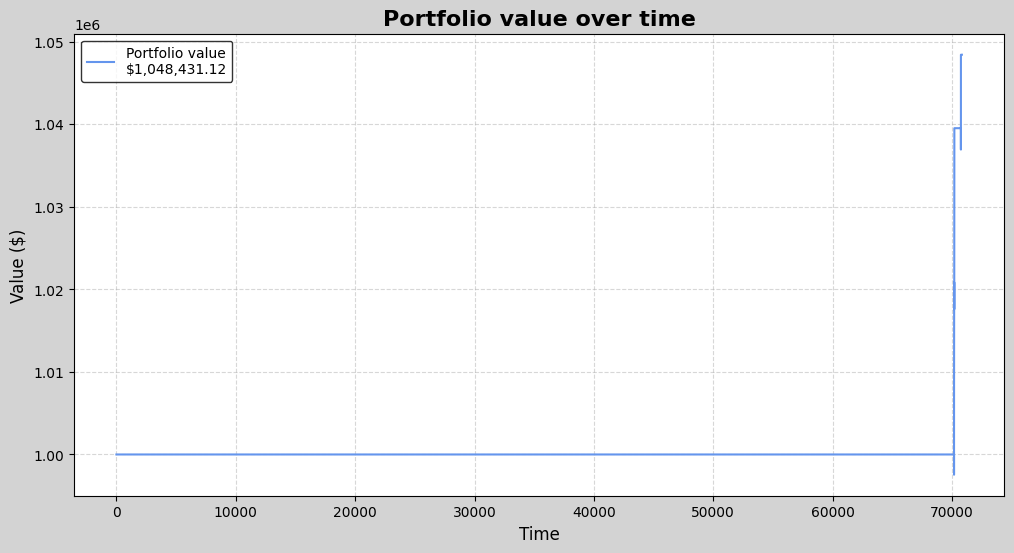

In [86]:
plt.figure()
plt.plot(portfolio_value, label=f'Portfolio value\n${capital:,.2f}', color= colors[0])
plt.title('Portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

Train , test , validation

In [87]:
data = data.copy()

Train, test, validation = dateset_split(data, 0.6, 0.2, 0.2)




NameError: name 'dateset_split' is not defined